$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# ACISDetector On Raw Binaries
<a id=ACISDetectorRaw></a>
In this part, we will examine our algorithms to classify binaries. Additionally, we'll write training loops and implement a modular model trainer. We'll use a few configurations for classifying architecture and instruction set with [isadetect]( https://github.com/kairis/isadetect) Raw Binaries Datasets.


In [1]:
import os
import re
import sys
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Architecture and instruction set
<a id=arch_is></a>
<!--isadetect 

@inproceedings{kairajarvi2020isadetect,
author={Kairaj\"arvi, Sami and Costin, Andrei and H\"am\"al\"ainen, Timo},
title={{ISAdetect: Usable Automated Detection of CPU Architecture and Endianness for Executable Binary Files and Object Code}},
booktitle={Proceedings of the Tenth ACM Conference on Data and Application Security and Privacy},
year={2020},
url="https://doi.org/10.1145/3374664.3375742"
}
-->

In this section, we want to try another approche to idintify architecture

In [3]:
import isadetect.helpers as isa_api 
import src.arch_v2_classifier as arch_api
import src.hyperparams as hp
from src.binary_dataset import FeatureDataset,DatasetToTuple,RawBinaryDataset
import src.arch_trainer as training

## Preprocessing 
We recommend to download this [dataset](https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/binary_raw.json.tar.gz) before you run this block. 
After the dataset has been downloaded, place it on: '.pytorch-datasets' folder which should be located in in your home folder

In [5]:
import pathlib
import tarfile
import urllib
import shutil
DOWNLOAD_URL = 'https://github.com/kfirgirstein/ACISDetector/releases/download/Dataset/binary_raw.json.tar.gz'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_dataset(out_path=DATA_DIR, url=DOWNLOAD_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    tar_out_filename = os.path.join(out_path, os.path.basename(url))
    out_filename = tar_out_filename[:tar_out_filename.find(".tar")]

    if os.path.isfile(out_filename) and not force:
        print(f'Dataset file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(tar_out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {tar_out_filename}.')

        tf = tarfile.open(tar_out_filename)
        tf.extractall(out_path)
        print(f"All dataset extracte\nYou can start working!.")
    return out_filename

DATASET_FILE = "./dataset/binary_raw.json"
if not os.path.isfile(DATASET_FILE):
    DATASET_FILE = download_dataset()
binary_dataset = RawBinaryDataset(DATASET_FILE)

Dataset file /home/kfirgirstein/.pytorch-datasets/binary_raw.json exists, skipping download.


In [6]:
N = len(binary_dataset)
batch_size = 32
print(f'features length: {N}')

features length: 115000


In [7]:
train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(binary_dataset,(train_length,test_length))
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

Train: 80500 samples
Test: 34500 samples


In [8]:
x0,y0 = ds_train[0]
dataset_shape = (x0.shape if x0.dim() > 0 else 1),(y0.shape if y0.dim() > 0 else 1)
print(x0.size(),y0.size())
print('input size =', dataset_shape[0], "X",dataset_shape[1] )

torch.Size([1000]) torch.Size([])
input size = torch.Size([1000]) X 1


Now after we downloaded the ELF binary dataset, we want to make two types of datasets:
- **Channeled Dataset** - We would like to treat the ELF as if it were an image. Where each section from the ELF files is a dimension of the image
- **Blob Matrix Dataset** - Each section will split to Rows, each row is 16 (0xF) bytes.
- **Long String Dataset** - We will treat our information as if it were one long text, so we will use work methodologies like NLP


#### Channeled Dataset

#### Blob Matrix Dataset

#### Long String Dataset

## Training
<a id=part2_3></a>

in order to plot our result and to compare them, we will use plot.py
and then we'll use the following function to load multiple experiment results and plot them together.

In [9]:
from jupyter_utils.plot import plot_fit, plot_exp_results
fig = None
fit_res = []

num_classes = 24
in_size = dataset_shape[0][0]
help(plot_fit)

Help on function plot_fit in module jupyter_utils.plot:

plot_fit(fit_res: src.train_results.FitResult, fig=None, log_loss=False, legend=None)
    Plots a FitResult object.
    Creates four plots: train loss, test loss, train acc, test acc.
    :param fit_res: The fit result to plot.
    :param fig: A figure previously returned from this function. If not None,
        plots will the added to this figure.
    :param log_loss: Whether to plot the losses in log scale.
    :param legend: What to call this FitResult in the legend.
    :return: The figure.



### MLP classifier

In [10]:
mlp_hp = hp.mlp_hp_raw()
print(mlp_hp)

{'hidden_size': [300], 'lr': 0.001, 'momentum': 0.9, 'dropout': 0.0}


In [11]:
if (os.path.isfile("checkpoints/mlp.pt")):
    print('*** Loading checkpoint file checkpoints/mlp.pt')
_mlp = arch_api.MLP(in_size,num_classes,mlp_hp['hidden_size'],mlp_hp['dropout'])
optimizer = torch.optim.SGD(_mlp.parameters(), lr=mlp_hp["lr"],momentum=mlp_hp['momentum'])
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_mlp, loss_fn, optimizer, device)
print(_mlp)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=1000, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=24, bias=True)
    (3): Softmax(dim=1)
  )
)


In [12]:
fit_res.append({"legend":"MLP","result":trainer.fit(dl_train,dl_test,num_epochs = 40,print_every=10,checkpoints="checkpoints/mlp")})

--- EPOCH 1/40 ---
test_batch (Avg. Loss 3.075, Accuracy 16.9): 100%|██████████| 1079/1079 [00:02<00:00, 478.41it/s]
*** Saved checkpoint checkpoints/mlp.pt at epoch 2
*** Saved checkpoint checkpoints/mlp.pt at epoch 3
*** Saved checkpoint checkpoints/mlp.pt at epoch 4
*** Saved checkpoint checkpoints/mlp.pt at epoch 5
*** Saved checkpoint checkpoints/mlp.pt at epoch 6
*** Saved checkpoint checkpoints/mlp.pt at epoch 9
*** Saved checkpoint checkpoints/mlp.pt at epoch 10
--- EPOCH 11/40 ---
test_batch (Avg. Loss 2.891, Accuracy 36.7): 100%|██████████| 1079/1079 [00:03<00:00, 350.25it/s]
*** Saved checkpoint checkpoints/mlp.pt at epoch 11
*** Saved checkpoint checkpoints/mlp.pt at epoch 12
*** Saved checkpoint checkpoints/mlp.pt at epoch 13
*** Saved checkpoint checkpoints/mlp.pt at epoch 14
*** Saved checkpoint checkpoints/mlp.pt at epoch 16
--- EPOCH 21/40 ---
test_batch (Avg. Loss 2.886, Accuracy 37.2): 100%|██████████| 1079/1079 [00:02<00:00, 501.53it/s]
*** Saved checkpoint checkpoi

### CNN conv1 classifier

In [13]:
cnn_hp = hp.cnn_hp()
print(cnn_hp)

{'lr': 0.0001, 'k': 8, 's': 6, 'h_c': [10, 100, 200], 'p': 0, 'd': 1}


In [14]:
if (os.path.isfile("checkpoints/cnn.pt")):
        print('*** Loading checkpoint file checkpoints/cnn.pt')
_cnn = arch_api.CNN(in_size,num_classes,kernel_size=cnn_hp["k"], stride=cnn_hp["s"], dilation = cnn_hp["d"],hidden_channels = cnn_hp["h_c"], padding = cnn_hp["p"])
optimizer = torch.optim.Adam(_cnn.parameters(), lr=cnn_hp["lr"])
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_cnn, loss_fn, optimizer, device)
print(_cnn)

CNN(
  (feature_extractor): Sequential(
    (0): Conv1d(1, 10, kernel_size=(8,), stride=(6,))
    (1): ReLU()
    (2): Conv1d(10, 100, kernel_size=(8,), stride=(6,))
    (3): ReLU()
    (4): Conv1d(100, 200, kernel_size=(8,), stride=(6,))
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=24, bias=True)
    (1): Softmax(dim=1)
  )
)


In [15]:
fit_res.append({"legend":"CNN","result":trainer.fit(dl_train,dl_test,num_epochs = 40,print_every=10,checkpoints="checkpoints/cnn")})

--- EPOCH 1/40 ---
test_batch (Avg. Loss 3.036, Accuracy 21.1): 100%|██████████| 1079/1079 [00:05<00:00, 203.65it/s]
*** Saved checkpoint checkpoints/cnn.pt at epoch 2
*** Saved checkpoint checkpoints/cnn.pt at epoch 3
*** Saved checkpoint checkpoints/cnn.pt at epoch 4
*** Saved checkpoint checkpoints/cnn.pt at epoch 5
*** Saved checkpoint checkpoints/cnn.pt at epoch 6
*** Saved checkpoint checkpoints/cnn.pt at epoch 7
*** Saved checkpoint checkpoints/cnn.pt at epoch 8
*** Saved checkpoint checkpoints/cnn.pt at epoch 9
*** Saved checkpoint checkpoints/cnn.pt at epoch 10
--- EPOCH 11/40 ---
test_batch (Avg. Loss 2.808, Accuracy 43.9): 100%|██████████| 1079/1079 [00:05<00:00, 186.31it/s]
*** Saved checkpoint checkpoints/cnn.pt at epoch 11
*** Saved checkpoint checkpoints/cnn.pt at epoch 12
*** Saved checkpoint checkpoints/cnn.pt at epoch 13
*** Saved checkpoint checkpoints/cnn.pt at epoch 15
*** Saved checkpoint checkpoints/cnn.pt at epoch 16
*** Saved checkpoint checkpoints/cnn.pt at ep

### RNN classifier

In [16]:
rnn_hp = hp.rnn_hp()
print(rnn_hp)

{'i_s': 50, 'l': 2, 'h_f': 512, 'lr': 0.0001}


In [17]:
if (os.path.isfile("checkpoints/rnn.pt")):
        print('*** Loading checkpoint file checkpoints/rnn.pt')
_rnn = arch_api.RNN(rnn_hp['i_s'],batch_size,num_classes,rnn_hp['l'],rnn_hp['h_f'])
optimizer =torch.optim.Adam(_rnn.parameters(), lr=rnn_hp["lr"])
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_rnn, loss_fn, optimizer, device)
print(_rnn)

RNN(
  (rnn): RNN(50, 512, num_layers=2)
  (label): Sequential(
    (0): Linear(in_features=1024, out_features=24, bias=True)
    (1): Softmax(dim=1)
  )
)


In [18]:
fit_res.append({"legend":"RNN","result":trainer.fit(dl_train,dl_test,num_epochs = 40,print_every=10,checkpoints="checkpoints/rnn")})

--- EPOCH 1/40 ---
test_batch (Avg. Loss 2.797, Accuracy 45.5): 100%|██████████| 1079/1079 [00:21<00:00, 50.47it/s]
*** Saved checkpoint checkpoints/rnn.pt at epoch 2
*** Saved checkpoint checkpoints/rnn.pt at epoch 3
*** Saved checkpoint checkpoints/rnn.pt at epoch 4
*** Saved checkpoint checkpoints/rnn.pt at epoch 5
*** Saved checkpoint checkpoints/rnn.pt at epoch 6
*** Saved checkpoint checkpoints/rnn.pt at epoch 7
*** Saved checkpoint checkpoints/rnn.pt at epoch 8
*** Saved checkpoint checkpoints/rnn.pt at epoch 9
--- EPOCH 11/40 ---
test_batch (Avg. Loss 2.584, Accuracy 66.5): 100%|██████████| 1079/1079 [00:21<00:00, 50.47it/s]
*** Saved checkpoint checkpoints/rnn.pt at epoch 13
*** Saved checkpoint checkpoints/rnn.pt at epoch 14
*** Saved checkpoint checkpoints/rnn.pt at epoch 15
*** Saved checkpoint checkpoints/rnn.pt at epoch 16
*** Saved checkpoint checkpoints/rnn.pt at epoch 17
--- EPOCH 21/40 ---
test_batch (Avg. Loss 2.527, Accuracy 72.2): 100%|██████████| 1079/1079 [00:21<

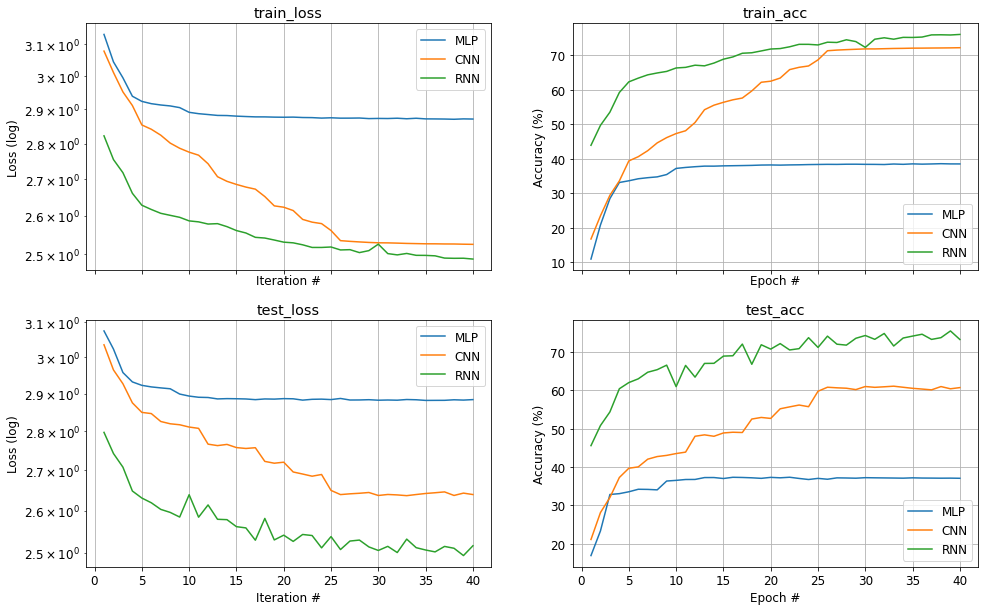

In [19]:
for elem in fit_res:
    fig, axes = plot_fit(elem['result'], fig, legend = elem['legend'],log_loss=True)
fig = []